# New York City Yellow Cab Fare Prediction with Classic Machine Learning.

### Yernat Assylbekov

In this project, we aim to predict taxi fares in New York City. It is a supervised, regression problem. For training, we use the data downloaded from Kaggle:
https://www.kaggle.com/dansbecker/new-york-city-taxi-fare-prediction

## Data wrangling and EDA.
###  Getting the data.

We download the data directly from the Kaggle website:


In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yernat","key":"edc93baf025a1e5773af952044c9a541"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d dansbecker/new-york-city-taxi-fare-prediction

  0% 0.00/1.50M [00:00<?, ?B/s]
100% 1.50M/1.50M [00:00<00:00, 49.7MB/s]


In [5]:
!unzip \*.zip

Archive:  new-york-city-taxi-fare-prediction.zip
  inflating: train.csv               


Now we can read the data into a `csv` file. For the project, we use Pandas.

In [0]:
import pandas as pd

In [0]:
df = pd.read_csv('train.csv', parse_dates=['pickup_datetime'])

Here, we also automatically converted the datatype of the `pickup_datetime` attribute to `datetime`.

### Data wrangling.

Let us first explore the dataset for its size, type, attributes and missing values.

In [3]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


The format of the data is suitable to work with. Column names are informative. Let us get some more information about the data.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
key                  50000 non-null object
fare_amount          50000 non-null float64
pickup_datetime      50000 non-null datetime64[ns, UTC]
pickup_longitude     50000 non-null float64
pickup_latitude      50000 non-null float64
dropoff_longitude    50000 non-null float64
dropoff_latitude     50000 non-null float64
passenger_count      50000 non-null int64
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 3.1+ MB


In our data we have the information for 50000 taxi trips. There are no missing values.

We start the wrangling process by making changes in the organization of the dataframe. As one can see, the `key` attribute is essentially the same as the `pickup_datetime` attribute. Therefore, it can be safely removed. Next, we partition the information in the `pickup_datetime` column into the columns `year`, `month`, `day`, `weekday` and `time`. The `time` column is minutes.

In [0]:
weekday_dict = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Th', 4: 'Fri', 5: 'Sat', 6: 'Sun'}

df['year'] = df.pickup_datetime.dt.year.astype(str)
df['month'] = df.pickup_datetime.dt.month.astype(str)
df['day'] = df.pickup_datetime.dt.day.astype(str)
df['weekday'] = df.pickup_datetime.dt.weekday.apply(lambda x: weekday_dict[x])
df['time'] = df.pickup_datetime.dt.hour * 60 + df.pickup_datetime.dt.minute

In [0]:
df.drop(columns=['key', 'pickup_datetime'], inplace=True)

Note that the columns `year`, `month`, `day`, `weekday` have string datatypes, i.e. cathegorical. The reason is that those columns will be converted to one-hot-encoders during modeling.

We also add one more column, namely `distance`, which represents the distance, in meters, between pick-up and drop-off locations.

In [0]:
from math import sin, cos, atan2, sqrt, pi, radians

r = 6378137.0

def dist(lon1, lat1, lon2, lat2):
    """computes the distance between the points (lon1, lat1) and (lon2, lat2)"""
    dlon = radians(lon2 - lon1)
    lat1, lat2 = radians(lat1), radians(lat2)
    dlat = lat2 - lat1
    a = (sin(dlat/2) ** 2) + cos(lat1) * cos(lat2) * (sin(dlon/2) ** 2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    return r * c

In [0]:
df['distance'] = df.apply(lambda row: dist(row.pickup_longitude, row.pickup_latitude, row.dropoff_longitude, row.dropoff_latitude), axis=1)

Next, we drop trips with zero `distance`.

In [0]:
df = df[df['distance'] != 0]

Now, the data looks clean.

In [10]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,weekday,time,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,Mon,1046,1031.918630
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,Tue,1012,8459.599708
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,Th,35,1391.081817
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,Sat,270,2802.406073
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,Tue,471,2001.396308


As we can see below, we got rid off about 1500 trips with zero `distance`.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48551 entries, 0 to 49998
Data columns (total 12 columns):
fare_amount          48551 non-null float64
pickup_longitude     48551 non-null float64
pickup_latitude      48551 non-null float64
dropoff_longitude    48551 non-null float64
dropoff_latitude     48551 non-null float64
passenger_count      48551 non-null int64
year                 48551 non-null object
month                48551 non-null object
day                  48551 non-null object
weekday              48551 non-null object
time                 48551 non-null int64
distance             48551 non-null float64
dtypes: float64(6), int64(2), object(4)
memory usage: 4.8+ MB


### Split the data to training and test sets.

We split the dataset to 90% as the training set and 10% as the test set.

In [0]:
from sklearn.model_selection import ShuffleSplit

splitter = ShuffleSplit(n_splits=1, test_size=0.1)

for train_index, test_index in splitter.split(df):
    df_train = df.iloc[train_index]
    df_test = df.iloc[test_index]

### Detecting outliers.

In the training set, to see possible outliers, we plot the boxplot and the histogram for the `fare_amount` column.

In [0]:
import matplotlib.pyplot as plt

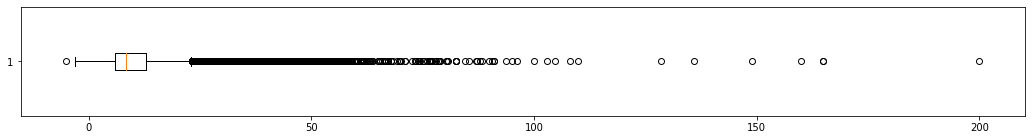

In [14]:
plt.figure(figsize=(18, 2))
plt.boxplot(df_train['fare_amount'], vert=False)
plt.show()

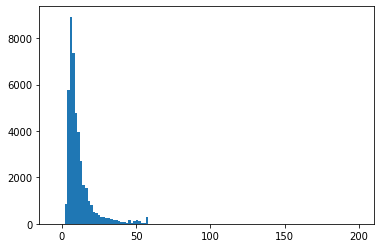

In [15]:
plt.hist(df_train['fare_amount'], bins=120, range=(df_train['fare_amount'].min(), df_train['fare_amount'].max()))
plt.show()

It is clear that `fare_amount` larger than 125 are very likely to be outliers. Also, `fare_amount` can not be negative. Therefore, we drop those rows.

In [16]:
df_train = df_train[(df['fare_amount'] >= 0) & (df_train['fare_amount'] <= 125)]
df_test = df_test[(df['fare_amount'] >= 0) & (df_test['fare_amount'] <= 125)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


### Correlations.

Let us study how much each numerical attribute is correlated with the `fare_amount` column.

In [17]:
df_train.corr().loc['fare_amount']

fare_amount          1.000000
pickup_longitude     0.020489
pickup_latitude     -0.016643
dropoff_longitude    0.013735
dropoff_latitude    -0.013762
passenger_count      0.021216
time                -0.023585
distance             0.016862
Name: fare_amount, dtype: float64

There are no clear correlations. But, it does not necessarily mean that there is no relation between these numerical attributes and the `fare_amount` attribute. The relation is likely more complicated.

### Preprocessing.
Now we separate our data by attributes into predictors and the target. In our case, the latter is the `fare_amount` attribute.

In [0]:
y_train = df_train['fare_amount']
X_train = df_train.drop(columns=['fare_amount'])

y_test = df_test['fare_amount']
X_test = df_test.drop(columns=['fare_amount'])

Next, we create a transformer that converts the categorical columns to one-hot-encoders and does standard rescaling of the numerical attributes. I prefer not to rescale one-hot-encoders.

In [0]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numerical_columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'time', 'distance']
categorical_columns = ['year', 'month', 'day', 'weekday']

preprocess = ColumnTransformer([('scaler', StandardScaler(), numerical_columns), ('encoder', OneHotEncoder(), categorical_columns)])

Finally, we apply this tranformer to our predictors (both in the training and the test sets).

In [0]:
X_train_rescaled = preprocess.fit_transform(X_train)
X_test_rescaled = preprocess.transform(X_test)

## Modeling and Predicition.

As a performance measure we work with RMSE. To analyze our models we need two functions that plot learning curves and plot RMSE on training and validation sets.

In [0]:
import numpy as np
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, cv):
    scoring = 'neg_mean_squared_error'
    train_sizes = np.array([0.05 * i for i in range(1,21)]) 
    
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes)

    plt.plot(train_sizes, np.mean(np.sqrt(-train_scores), axis=1), 'r', label='train_scores')
    plt.plot(train_sizes, np.mean(np.sqrt(-val_scores), axis=1), 'b', label='val_scores')
    plt.legend(labels=['train_scores', 'val_scores'], loc='upper left')
    plt.show()

    print('mean of RMSE on training set: {}'.format(np.mean(np.sqrt(-train_scores[-1,:]))))
    print('mean of RMSE on validation set: {}'.format(np.mean(np.sqrt(-val_scores[-1,:]))))

Now, we are ready to build and train our models. But before that, we look at the statistics of `y_train`:

In [22]:
y_train.describe()

count    43683.000000
mean        11.372162
std          9.408761
min          0.000000
25%          6.000000
50%          8.500000
75%         12.900000
max        110.000000
Name: fare_amount, dtype: float64

### Try several rough models.

#### Linear Regression.

Let us start with the Linear Regression as the base model.

In [0]:
from sklearn.linear_model import LinearRegression

linear = LinearRegression()

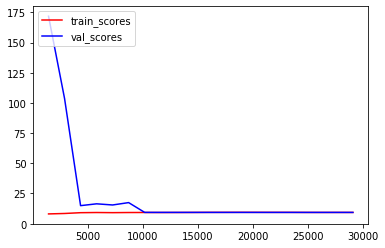

mean of RMSE on training set: 9.29978715526542
mean of RMSE on validation set: 9.320427902484338


In [24]:
plot_learning_curve(linear, X_train_rescaled, y_train, 3)

As expected, the Linear Regression is underfitting.

#### Decision Tree Regression.

Next, we try a Decision Tree which is a powerful model which is capable to learn complex nonlinear models.

In [0]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(criterion='mse', max_depth=16, max_features='auto')

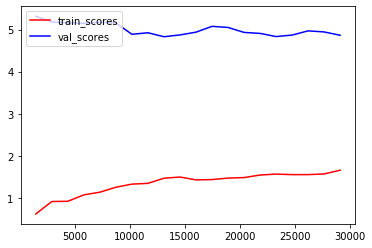

mean of RMSE on training set: 1.6573580075623076
mean of RMSE on validation set: 4.862663913736


In [26]:
plot_learning_curve(tree, X_train_rescaled, y_train, 3)

However, it is prone to overfitting.

#### Random Forest Regression.

Random Forest is an ensemble of several Decision Trees. Often, they show better performance than Decision Trees.

In [0]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(criterion='mse', n_estimators=16, max_depth=16, n_jobs=-1, random_state=13)

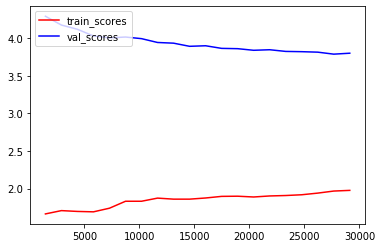

mean of RMSE on training set: 1.9757137905463849
mean of RMSE on validation set: 3.802463652923557


In [28]:
plot_learning_curve(forest, X_train_rescaled, y_train, 3)

Random Forest is also prone to overfitting. However, currently it is overfitting slightly less than the Decision Tree.

#### Gradient Boosting Regression.
Gradient Boosting is an algorithm which improves Decision Tree in stage-wise fashion.

In [0]:
from sklearn.ensemble import GradientBoostingRegressor

gradboost = GradientBoostingRegressor(n_estimators=16, max_depth=16, criterion='mse', subsample=0.1, random_state=13)

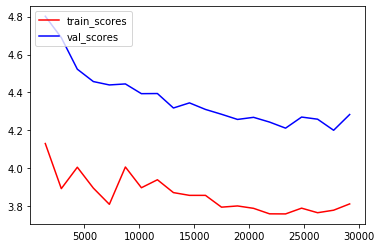

mean of RMSE on training set: 3.811930075930005
mean of RMSE on validation set: 4.283588112045753


In [30]:
plot_learning_curve(gradboost, X_train_rescaled, y_train, 3)

It is clearly underfitting.

### Fine-tune the Models in the List.

Next, we fine tune each of the following models: Decision Trees, Random Forests and Gradient Boosting.

In [0]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#### Fine-tuning the Decision Tree Regression.

Recall that the Decision Tree was overfitting, so we fine tune the model by considering `max_depth` smaller than 16. We also look at different modes of `max_features`.

In [0]:
tree_search = GridSearchCV(tree, param_grid={'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [8, 12, 16]},
                           n_jobs=-1, cv=3, scoring='neg_mean_squared_error')

In [33]:
tree_search.fit(X_train_rescaled, y_train)
tree_search.best_params_

{'max_depth': 8, 'max_features': 'auto'}

In [0]:
tree_best = tree_search.best_estimator_

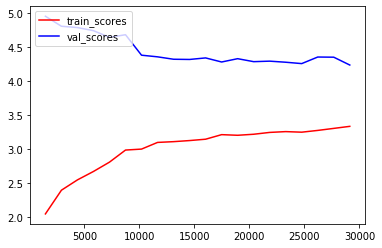

mean of RMSE on training set: 3.331844105409902
mean of RMSE on validation set: 4.234917658678501


In [35]:
plot_learning_curve(tree_best, X_train_rescaled, y_train, 3)

The Decision Tree did not really improve. It switched from badly overfitting to badly underfitting.

#### Fine-tuning the Random Forest Regression.

Random Forest was also overfitting. Hence, we fine tune the model by considering `max_depth` also smaller than 16. We also look at different modes of `max_features`.

In [0]:
forest_search = GridSearchCV(forest, param_grid={'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 8, 12], 'n_estimators': [10, 12, 14]},
                             n_jobs=-1, cv=3, scoring='neg_mean_squared_error')

In [37]:
forest_search.fit(X_train_rescaled, y_train)
forest_search.best_params_

{'max_depth': 12, 'max_features': 'auto', 'n_estimators': 14}

In [0]:
forest_best = forest_search.best_estimator_

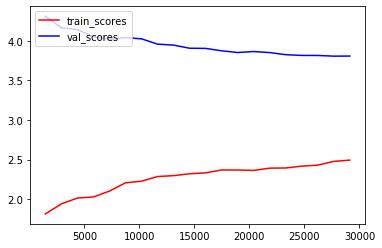

mean of RMSE on training set: 2.49307181722295
mean of RMSE on validation set: 3.806814634513757


In [39]:
plot_learning_curve(forest_best, X_train_rescaled, y_train, 3)

It is still overfitting, but slightly less than it was earlier.

#### Fine-tuning the Gradient Boosting Regression.

Finally, we fine tune Gradient Boosting. Since it was underfitting, we consider larger `n_estimators` and `max_depth`. We also look at different learning rates and loss functions to minimize. However, the learning curve shows RMSE.

In [0]:
gradboost_search = GridSearchCV(gradboost, param_grid={'learning_rate': [0.1, 0.01, 0.001], 'loss': ['ls', 'lad', 'huber'],
                                                       'n_estimators': [16, 32, 64, 128], 'max_depth': [14, 16, 20]},
                                n_jobs=-1, cv=3, scoring='neg_mean_squared_error')

In [41]:
gradboost_search.fit(X_train_rescaled, y_train)
gradboost_search.best_params_

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 14, 'n_estimators': 128}

In [0]:
gradboost_best = gradboost_search.best_estimator_

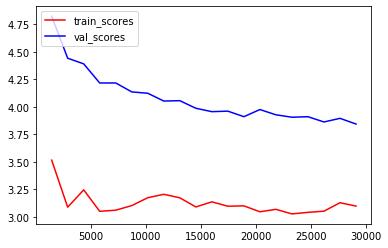

mean of RMSE on training set: 3.0980385822740715
mean of RMSE on validation set: 3.843871802560812


In [43]:
plot_learning_curve(gradboost_best, X_train_rescaled, y_train, 3)

As we can see, performance of Gradient Boosting is slightly improved.

### Try to ensemble the selected models.

Let us try to ensemble the earlier fine-tuned Random Forest and Gradient Boosting models.

In [0]:
from sklearn.ensemble import VotingRegressor

In [0]:
ensembled = VotingRegressor(estimators=[('gradboost', gradboost_best), ('forest', forest_best)], n_jobs=-1)

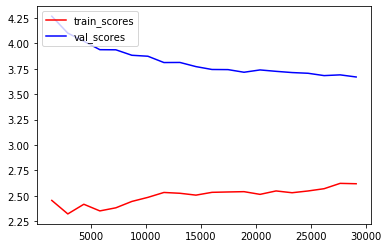

mean of RMSE on training set: 2.618495340091632
mean of RMSE on validation set: 3.669473218331401


In [46]:
plot_learning_curve(ensembled, X_train_rescaled, y_train, 3)

Ensembled model gave us better performance.

### Final training of the ensembled model.

Next, we train our ensembled model on the whole training set.

In [0]:
final = ensembled

In [48]:
final.fit(X_train_rescaled, y_train)

VotingRegressor(estimators=[('gradboost',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='lad', max_depth=14,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                    

### Test.

Lasly, we look at the performance of our final model on the testing set.

In [0]:
from sklearn.metrics import mean_squared_error

In [50]:
y_predict_train = final.predict(X_train_rescaled)
y_predict_test = final.predict(X_test_rescaled)

train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict_test)

print('RMSE on the training set: ' + str(np.sqrt(train_mse)))
print('RMSE on the test set: ' + str(np.sqrt(test_mse)))

RMSE on the training set: 2.7199176967207475
RMSE on the test set: 3.441977679095276


The model performed pretty well on the testing set.

## Conclusion.

In this project, we conducted an end-to-end machine learning study, including data cleaning, feature generation, some data visualization for detecting the outliers, preprocessing, selection machine learning models, fine-tuning of hyperparameters and testing. One important thing that was not considered in the project is the exploratory analyis. That would be interesting to study and it could give more insight about the data. It would also be interesting to explore how weather conditions affect taxi fares. All of those could improve the performance our model.

Finally, another interesting approach for predicting taxi fares would be to use Deep Learning. But those models overperform classical machine learning algorithms if one has a huge number of data. Look at the graph below.

<img src="DL_vs_ML.png" style="width:537px;height:350px;">